## Часть 1. Подготовка данных

In [1]:
! pip install torchinfo
! pip install gdown

In [2]:
# Импорт необходимых библиотек
import os
import cv2
import gdown
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from pathlib import Path
from torchinfo import summary
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import clear_output
from matplotlib.gridspec import GridSpec
from torchvision import transforms, models
from sklearn.metrics import accuracy_score
from PIL import Image, ImageDraw, ImageFile
from torchvision.datasets import ImageFolder
from sklearn.model_selection import LeaveOneOut
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True
sns.set(style='darkgrid', font_scale=1.2)

In [3]:
# Зафиксируем рендом
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# Определим device
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')  
device

device(type='cuda', index=0)

In [5]:
# Выведем информацию о видеоадаптере при его наличии
if device.type == 'cuda':
    !nvidia-smi

Sat Jan  8 23:06:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:07:00.0  On |                  N/A |
| 29%   37C    P8    10W / 160W |   1395MiB /  6144MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

In [4]:
# Загрузим и распакуем датасет
gdown.cached_download("https://drive.google.com/u/0/uc?export=download&confirm=4yJt&id=1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9",
                      'faces_dataset_small.zip',
                      quiet=False,
                      postprocess=gdown.extractall)

Cached Downloading: faces_dataset_small.zip
Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=4yJt&id=1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9
To: C:\Users\User\.cache\gdown\tmpx8cby3t2\dl
100%|██████████| 4.28G/4.28G [06:17<00:00, 11.3MB/s]


'faces_dataset_small.zip'

In [6]:
BASE_DIR = Path('./')                     # Базовая директория
DATA_DIR = Path('./faces_dataset_small')  # Директория, содержащая датасет

In [7]:
# Подготовим список файлов
image_files = sorted(list(DATA_DIR.rglob('*.png')))
print(f'Датасет содержит {len(image_files)} изображения')

Датасет содержит 3143 изображения


In [8]:
class FacesDataset(Dataset):
    """
    Датасет с картинками, который параллельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, rescale_size):
        super().__init__()
        # Список файлов для загрузки
        self.files = sorted(files)
        # Размер, в который нужно преобразовать изображение
        self.rescale_size = rescale_size
        # Количество файлов
        self.len_ = len(self.files)
        # Базовые трансформации
        self.base_transforms = transforms.Compose([
            transforms.Resize(self.rescale_size),
            transforms.CenterCrop(self.rescale_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Нормализуем -1 ... 1
        ])    
        # Соберём датасет с применением трансформаций в тензор
        self.dataset = torch.empty(size=(self.len_, 3, self.rescale_size, self.rescale_size))
        for i, image_path in enumerate(self.files):
            image = Image.open(image_path)
            self.dataset[i] = self.base_transforms(image)
                     
    def __len__(self):
        return self.len_
      
    def __getitem__(self, index):
        # Преобразования изображений и перевод их в тензоры PyTorch
        transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5)])     
        x = self.dataset[index]
        x = transform(x)
        return x

In [9]:
image_size = 256                                                        # Итоговый размер изображения
batch_size = 32                                                         # Размер батча
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)                                # Средние и стандартные отклонения
dataset = FacesDataset(image_files, rescale_size=image_size)            # Создадим датасет
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # Создадим даталоадер

In [10]:
def norm(img_tensors):
    '''Функция для нормализации от (-1 ... 1) к (0 ... 1)'''
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=32):
    '''Функция для отрисовки изображений в сетке'''
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(norm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
        
def show_batch(dl, nmax=32):
    '''Функция для извлечения изображений из батча даталоадера'''
    for images in dl:
        show_images(images, nmax)
        break

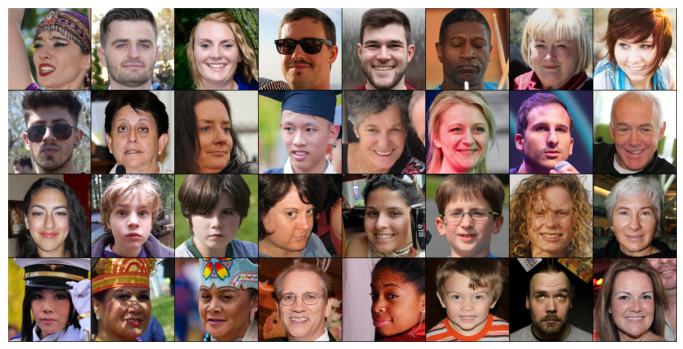

In [12]:
show_batch(data_loader)  # Визуализируем изображения из батча

## Часть 2. Построение и обучение модели

Соберём генератор и дискриминатор.
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [13]:
def weights_init(m):
    '''Функция для инициализации весов'''
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
class GaussianNoise(nn.Module): 
    '''Добавляет Гауссов шум'''
    def __init__(self, std=0.1):
        super().__init__()
        self.std = std

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [15]:
class Generator(nn.Module):
    def __init__(self, latent_size=128):
        super(Generator, self).__init__()
        
        self.latent_size = latent_size
        
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels=self.latent_size, out_channels=2048, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            nn.ConvTranspose2d(in_channels=2048, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh())
        
    def forward(self, input):
        return self.main(input)

In [16]:
summary(Generator().to('cpu').apply(weights_init), (batch_size, Generator().latent_size, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─Sequential: 1-1                        [32, 3, 256, 256]         --
│    └─ConvTranspose2d: 2-1              [32, 2048, 4, 4]          4,194,304
│    └─BatchNorm2d: 2-2                  [32, 2048, 4, 4]          4,096
│    └─ReLU: 2-3                         [32, 2048, 4, 4]          --
│    └─Dropout: 2-4                      [32, 2048, 4, 4]          --
│    └─ConvTranspose2d: 2-5              [32, 1024, 8, 8]          33,554,432
│    └─BatchNorm2d: 2-6                  [32, 1024, 8, 8]          2,048
│    └─ReLU: 2-7                         [32, 1024, 8, 8]          --
│    └─Dropout: 2-8                      [32, 1024, 8, 8]          --
│    └─ConvTranspose2d: 2-9              [32, 512, 16, 16]         8,388,608
│    └─BatchNorm2d: 2-10                 [32, 512, 16, 16]         1,024
│    └─ReLU: 2-11                        [32, 512, 16,

In [17]:
class Discriminator(nn.Module):
    def __init__(self, std=0.1):
        super(Discriminator, self).__init__()
        
        self.std = std
        
        self.main = nn.Sequential(
            GaussianNoise(self.std),
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            
            GaussianNoise(self.std),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            GaussianNoise(self.std),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            GaussianNoise(self.std),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            GaussianNoise(self.std),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            GaussianNoise(self.std),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
            
            GaussianNoise(self.std),
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid())
    
    def forward(self, input):
        return self.main(input)

In [18]:
summary(Discriminator().to('cpu').apply(weights_init), (batch_size, 3, image_size, image_size))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [32, 1]                   --
│    └─GaussianNoise: 2-1                [32, 3, 256, 256]         --
│    └─Conv2d: 2-2                       [32, 32, 128, 128]        1,536
│    └─LeakyReLU: 2-3                    [32, 32, 128, 128]        --
│    └─GaussianNoise: 2-4                [32, 32, 128, 128]        --
│    └─Conv2d: 2-5                       [32, 64, 64, 64]          32,768
│    └─BatchNorm2d: 2-6                  [32, 64, 64, 64]          128
│    └─LeakyReLU: 2-7                    [32, 64, 64, 64]          --
│    └─GaussianNoise: 2-8                [32, 64, 64, 64]          --
│    └─Conv2d: 2-9                       [32, 128, 32, 32]         131,072
│    └─BatchNorm2d: 2-10                 [32, 128, 32, 32]         256
│    └─LeakyReLU: 2-11                   [32, 128, 32, 32]         --
│

Визуализируем шум, из которого будут генерироваться изображения

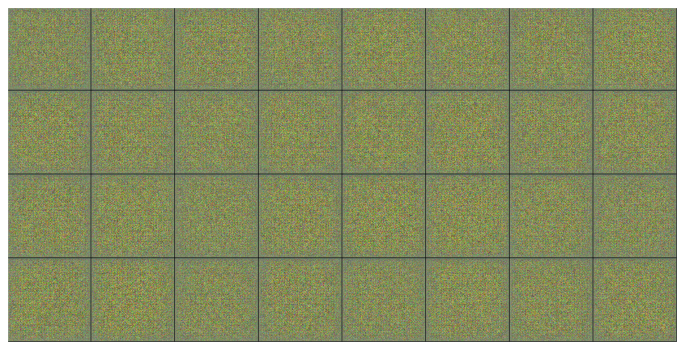

In [19]:
xb = torch.randn(batch_size, Generator().latent_size, 1, 1) 
fake_images = Generator()(xb)
show_images(fake_images)

In [20]:
# Класс и функция для переноса изображений даталоадера на device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device      
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
data_loader = DeviceDataLoader(data_loader, device)  # Перенесём изображения даталоадера на device

In [22]:
sample_dir = 'generated'  # Создадим папку для сохранения сгенерированных изображений
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(model, index, latent_tensors, show=True):
    '''Функция для сохранения в директорию изображений созданных
    генератором с возможностью их визуализации'''
    fake_images = model(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(norm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(norm(fake_images.cpu().detach()), nrow=8).permute(1, 2, 0))

Обучение GAN:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса


2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 1
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [24]:
# Определим модели
model = {
    "discriminator": Discriminator().to(device).apply(weights_init),
    "generator": Generator().to(device).apply(weights_init)
}

# Определим Loss функции для двух моделей
criterion = {
    "discriminator": nn.BCELoss(), 
    "generator": nn.BCELoss() 
}

# Определим оптимизаторы для двух моделей
optimizer = {
    "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                      lr=4e-4, betas=(0.5, 0.999)),         # Установим Learning Rate для дискриминатора
    "generator": torch.optim.Adam(model["generator"].parameters(),
                                  lr=1e-4, betas=(0.5, 0.999))              # Установим Learning Rate для генератора
    }

In [25]:
def fit(model, criterion, epochs, optimizer, start_idx=1):
    # Переведём модели в режим обучения
    model["discriminator"].train()
    model["generator"].train()
    # Очистим кеш
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(data_loader):
            
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = (1-0.9)*torch.rand(real_images.size(0), 1, device=device)+0.9  # вероятность от 0.9 до 1
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, model["generator"].latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_preds = model["discriminator"](fake_images)
            fake_targets = (0.1)*torch.rand(fake_images.size(0), 1, device=device)  # вероятность от 0 до 0.1
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, model["generator"].latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Visualisations
        clear_output(wait=True)
    
        fig = plt.figure(figsize=(10, 5))
        fig.suptitle(("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1])))

        gs1 = GridSpec(2, 5, left=0.0001, right=0.95, wspace=0.05)
        
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax1.imshow(norm(fake_images[0].detach().cpu().permute(1,2,0)))
        ax1.axis('off') 
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax2.imshow(norm(fake_images[1].detach().cpu().permute(1,2,0)))
        ax2.axis('off') 
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax3.imshow(norm(fake_images[2].detach().cpu().permute(1,2,0)))
        ax3.axis('off') 
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax4.imshow(norm(fake_images[3].detach().cpu().permute(1,2,0)))
        ax4.axis('off') 
        ax5 = fig.add_subplot(gs1[:-1, -1])
        ax5.imshow(norm(fake_images[4].detach().cpu().permute(1,2,0)))
        ax5.axis('off') 
        ax6 = fig.add_subplot(gs1[-1, :1])
        ax6.imshow(norm(fake_images[5].detach().cpu().permute(1,2,0)))
        ax6.axis('off') 
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax7.imshow(norm(fake_images[6].detach().cpu().permute(1,2,0)))
        ax7.axis('off')
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax8.imshow(norm(fake_images[7].detach().cpu().permute(1,2,0)))
        ax8.axis('off')
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax9.imshow(norm(fake_images[8].detach().cpu().permute(1,2,0)))
        ax9.axis('off')
        ax10 = fig.add_subplot(gs1[-1, 4])
        ax10.imshow(norm(fake_images[9].detach().cpu().permute(1,2,0)))
        ax10.axis('off')

        gs2 = GridSpec(2, 2, left=1.01, right=2.0, hspace=0.05)
        
        ax11 = fig.add_subplot(gs2[:, :-1])
        ax11.plot(np.arange(len(losses_g)), losses_g, label='Generator')
        ax11.plot(np.arange(len(losses_d)), losses_d, label='Discriminator')
        ax11.set_ylim(0, max(losses_g+losses_g)+0.5)
        ax11.set_xlabel('Epoch')
        ax11.set_title('Losses')
        ax11.legend()

        plt.show()
    
        # Save generated images every 100 epochs
        if epoch % 100 == 0:
            # Cоздадим фиксированный латентный вектор для генерации изображений
            fixed_latent = torch.randn(batch_size, model["generator"].latent_size, 1, 1, device=device)
            save_samples(model["generator"], epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

Проведём обучение модели в течение 500 эпох

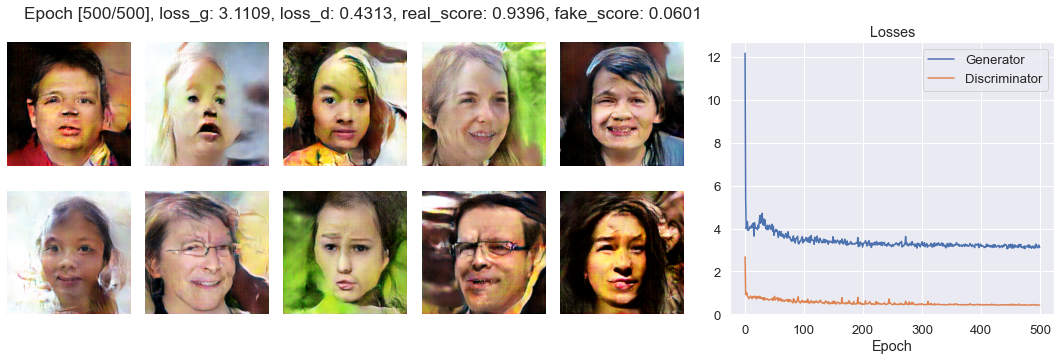

In [26]:
history = fit(model, criterion, 500, optimizer)

In [27]:
# Save Generator
torch.save(model["generator"].state_dict(), 'generator_v10.pt')

# Save Discriminator
torch.save(model["discriminator"].state_dict(), 'discriminator_v10.pt')

In [28]:
# Определим модели
model = {
    "discriminator": Discriminator().to(device),
    "generator": Generator().to(device)
}

# Load Generator
model["generator"].load_state_dict(torch.load('generator_v10.pt', map_location=device))
model["generator"].eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inpla

In [29]:
# Load Discriminator
model["discriminator"].load_state_dict(torch.load('discriminator_v10.pt', map_location=device))
model["discriminator"].eval()

Discriminator(
  (main): Sequential(
    (0): GaussianNoise()
    (1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): LeakyReLU(negative_slope=0.2)
    (3): GaussianNoise()
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): GaussianNoise()
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): GaussianNoise()
    (12): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2)
    (15): GaussianNoise()
    (16): Conv2d(256, 512, kernel_size=(4, 4), stride=(2,

In [30]:
# Сохраним значения loss и score в переменные
losses_g, losses_d, real_scores, fake_scores = history

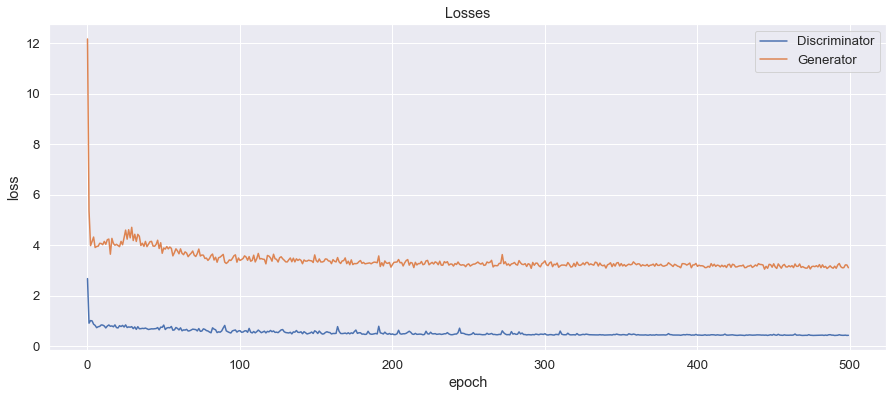

In [31]:
# Построим графики лоссов
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

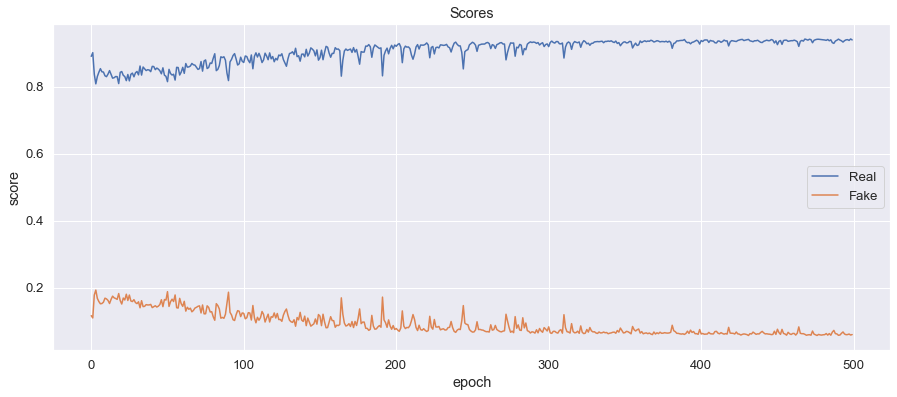

In [32]:
# Построим графики скоров
plt.figure(figsize=(15, 6))
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Графики лоссов двух сетей начиная с 10-ой эпохи стабильны, без значительных отклонений. Ни одна из сетей не побеждает. Лосс генератора держится около значения 3, лосс дискриминатора около значения 0.4. Дальнейшее обучение не приводит к повышению качество генерируемых изображений.

## Часть 3. Генерация изображений 

In [33]:
n_images = 64                                                                              # Количество генерируемых изображений
fixed_latent = torch.randn(n_images, model["generator"].latent_size, 1, 1, device=device)  # Создадим латентный вектор
fake_images = model["generator"](fixed_latent)                                             # Сгенерируем изображения

In [34]:
def show_images(fake_images):
    '''Функция для визуализации изображений созданных генератором'''
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(norm(fake_images.cpu().detach()), nrow=8).permute(1, 2, 0))

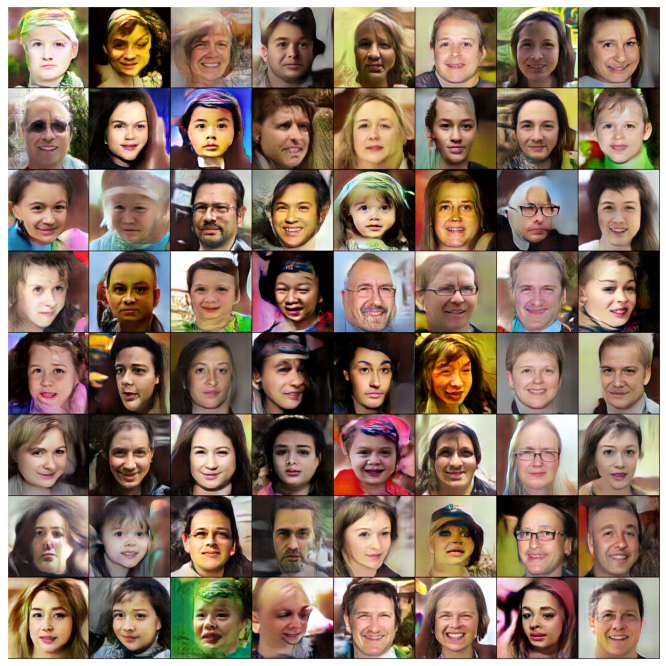

In [35]:
show_images(fake_images)  # Визуализируем сгенерированные изображения

Изображения получились достаточно чёткие, без большого количества шума на них. Лица довольно чистые, некоторые из них получились практически без искажений, но часть изображений содержит артефакты. Повторяющиеся лица не наблюдаются. Для достижения лучшего качества нужно, как миниммум, расширять датасет и использовать современные архитектуры сетей.

## Часть 4. Leave-one-out-1-NN classifier accuracy

### 4.1. Подсчет accuracy 

* Сгенерируем столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоим фейковым метку класса 0, настоящим – 1.
* Построим leave-one-out оценку: обучим 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверим качество (accuracy) на оставшемся объекте (`sklearn.model_selection.LeaveOneOut`).

In [36]:
# Подготовим тензор с реальными изображениями
real_images = torch.FloatTensor()

iterator = iter(data_loader)
for i in range(len(data_loader)):
    batch_images = next(iterator)
    real_images = torch.cat((real_images, batch_images.cpu()))
    
print(f'real_images size = {real_images.shape}')

real_images size = torch.Size([3143, 3, 256, 256])


In [37]:
# Подготовим тензор с метками класса для реальных изображений
real_ones = torch.ones(len(dataset), 1, device='cpu')
print(f'real_ones size = {real_ones.shape}')

real_ones size = torch.Size([3143, 1])


In [38]:
# Подготовим тензор с фейковыми изображениями
z = torch.randn(len(dataset), model["generator"].latent_size, 1, 1, device='cpu')
with torch.no_grad():
    fake_images = model["generator"].to('cpu')(z)
print(f'fake_images size = {fake_images.shape}')

fake_images size = torch.Size([3143, 3, 256, 256])


In [39]:
# Подготовим тензор с метками класса для фейковых изображений
fake_zeros = torch.zeros(len(dataset), 1, device='cpu')
print(f'fake_zeros size = {fake_zeros.shape}')

fake_zeros size = torch.Size([3143, 1])


In [40]:
# Объединим реальные и фейковые изображения в один тензор
all_images = torch.cat((real_images, fake_images))
all_images = torch.reshape(all_images, (all_images.shape[0], -1))
print(f'all_images size = {all_images.shape}')

all_images size = torch.Size([6286, 196608])


In [41]:
# Объединим реальные и фейковые лейблы в один тензор
all_labels = torch.cat((real_ones, fake_zeros)).ravel()
print(f'all_labels size = {all_labels.shape}')

all_labels size = torch.Size([6286])


In [42]:
# Построим leave-one-out оценку
clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
loo = LeaveOneOut()

accuracy_list = []
classes_list = []

for train_index, test_index in loo.split(all_images):
    X_train, X_test = all_images[train_index], all_images[test_index]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
    classes_list.append(y_test)

In [43]:
# Точность предсказаний по классам
df = pd.DataFrame(data={'classes': classes_list, 'accuracy': accuracy_list}, dtype='int32')
df.pivot_table(values='accuracy', index='classes', aggfunc='mean')

,accuracy
classes,
0,0.762329
1,0.712377


In [44]:
# Общая точность 1NN
round(df['accuracy'].mean(), 2)

0.74

Нам хотелось бы получить общую точность и точность по классам около 0.5. В этом случае реальные и фейковые изображения распределены равномерно и не кластеризованы, и классификатор не может достоверно отличить их друг от друга. Я использовал попиксельное сравнение и достиг общей точности 0.74 при том, что качество генерируемых изображений довольно высокое. На одном из прогонов блокнота мне удалось достигнуть точности 0.61 не смотря на то, что качество генерируемых изображений было значительно хуже. Вероятно, нужно учитывать гамму\яркость\цветовую палитру генерируемых изображений и то, насколько эти значения отличаются от значения реальных изображений. Конечно, этот фактор должен нивелироваться на большом датасете, но в данном случае данных довольно мало и это могло повлиять на качество оценки точности. Для получения более качественной оценки точности вместо попиксельного сравнения можно использовать feature extractor на базе свёрточной сети или энкодер, что позволит проводить оценку на полученных features \ latent. Подход с использованием энкодеров имеет и свои минусы, т.к. энкодеры кодируют только основные признаки сглаживая мелкие детали, что может частично уменьшить разницу между реальными и фейковыми изображениями. По этому подход с применением feature extractor является наиболее качественным, но и наиболее сложным в реализации.

### 4.2. Визуализация распределений 

Посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуемся методом, снижающим размерность (к примеру, TSNE) и изобразим на графике разным цветом точки, соответствующие реальным и сгенерированным изображениям.

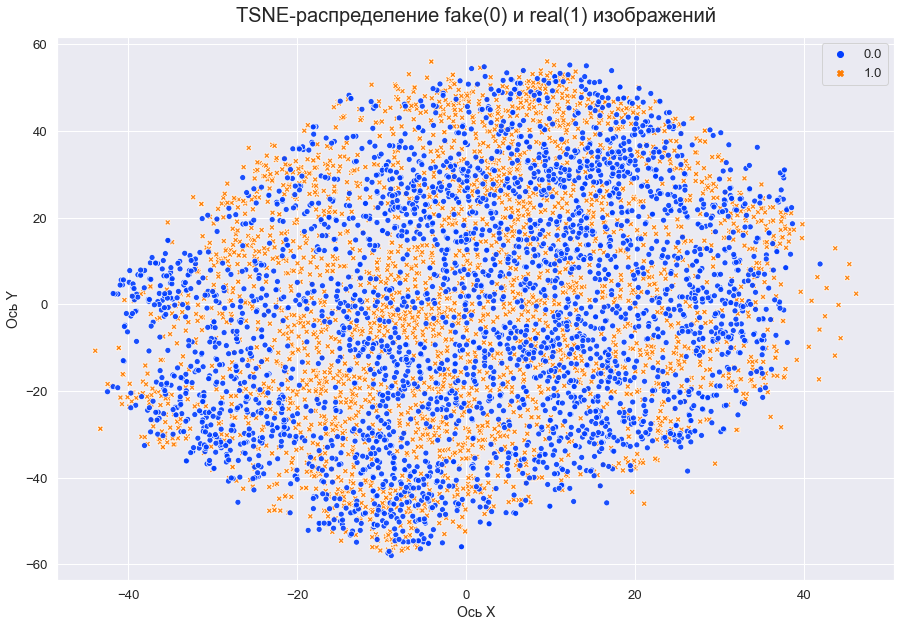

In [45]:
# Построим TSNE распределение
all_images_tsne = TSNE(n_components=2, n_jobs=-1).fit_transform(all_images)

fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x=all_images_tsne[:, 0], y=all_images_tsne[:, 1], hue=all_labels, palette='bright', style=all_labels, alpha=0.9)
ax.set_title('TSNE-распределение fake(0) и real(1) изображений', fontsize=20, pad=15)
ax.set_xlabel('Ось X', fontsize=14)
ax.set_ylabel('Ось Y', fontsize=14)
plt.show()

Данные распределены достаточно равномерно, но визуально заметны небольшие кластеры как реальных, так и фейковых изображений. Это коррелируется с полученной точностью по классам.